# Datasets

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import refined_tangram as tg
import tangram_add_ons as tgx
import anndata as an
from anndata import AnnData

sc.logging.print_header()
import squidpy as sq
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

## MERFISH mouse hypothalamus dataset

In [59]:
adata_sc = sq.datasets.merfish()
adata_sc = adata_sc[adata_sc.obs.Bregma == -9]
adata_sc.obs["cell_types"] = adata_sc.obs['Cell_class']
del adata_sc.obs['Cell_class']

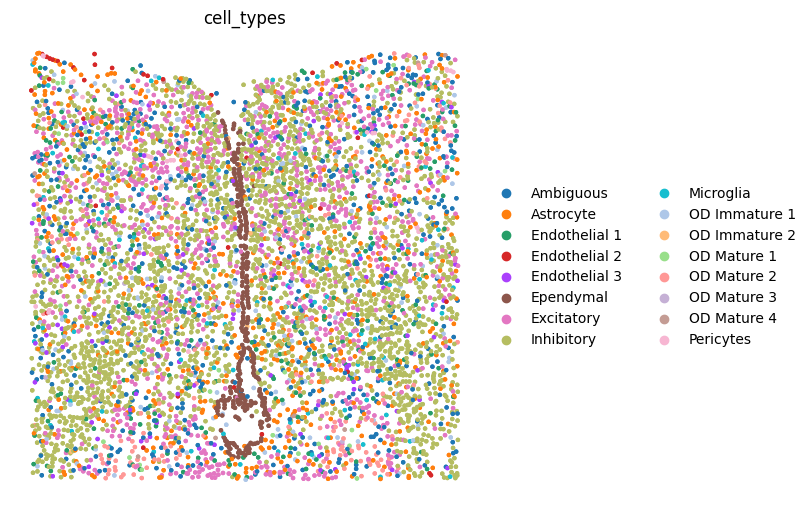

In [189]:
sq.pl.spatial_scatter(
    adata_sc, shape=None, color="cell_types", frameon=False, figsize = (10,5),# return_ax=True# ax=ax
)

In [ ]:
min_x = adata_sc.obsm["spatial"][:,0].min()
min_y = adata_sc.obsm["spatial"][:,1].min()
max_x = adata_sc.obsm["spatial"][:,0].max()
max_y = adata_sc.obsm["spatial"][:,1].max()
xgrid, ygrid  = np.meshgrid(np.linspace(min_x, max_x, 25),np.linspace(min_y, max_y, 25))

In [61]:
adata_st = tgx.generate_adata_st(adata_sc, xgrid, ygrid, cell_cover=1.0,min_cell_count=3)

100%|██████████| 25/25 [00:02<00:00, 10.87it/s]

proportion of selected cells: 0.9964430072756669


<Axes: >

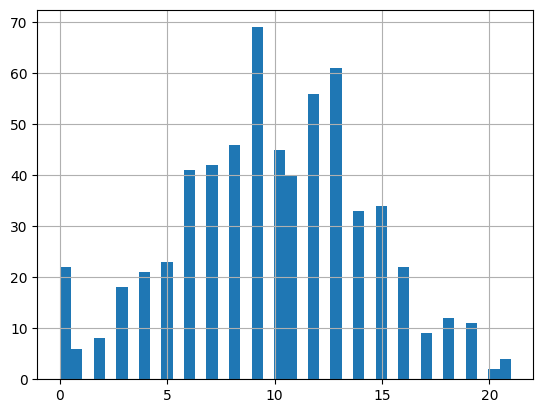

In [47]:
adata_st.obs['cell_count'].hist(bins=40)

In [48]:
adata_st[adata_st.obs['cell_count'] >= 3].obs['cell_count'].mean()

10.463497453310696

In [62]:
adata_st = adata_st[adata_st.obs['cell_count'] >= 3]

In [64]:
tgx.cells2spots(adata_sc, adata_st)

In [65]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)

In [34]:
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

In [35]:
import matplotlib.colors as cm
labels = adata_sc.obs["cell_types"].unique().tolist()
labels.sort()
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)] + ["gold", "khaki", "lightseagreen"]

In [43]:
adata_sc.obs['selected_for_adata_st_filtered']

41437-4    True
41438-4    True
41439-4    True
41440-4    True
41441-4    True
           ... 
47617-4    True
47618-4    True
47619-4    True
47620-4    True
47621-4    True
Name: selected_for_adata_st_filtered, Length: 6179, dtype: bool

16


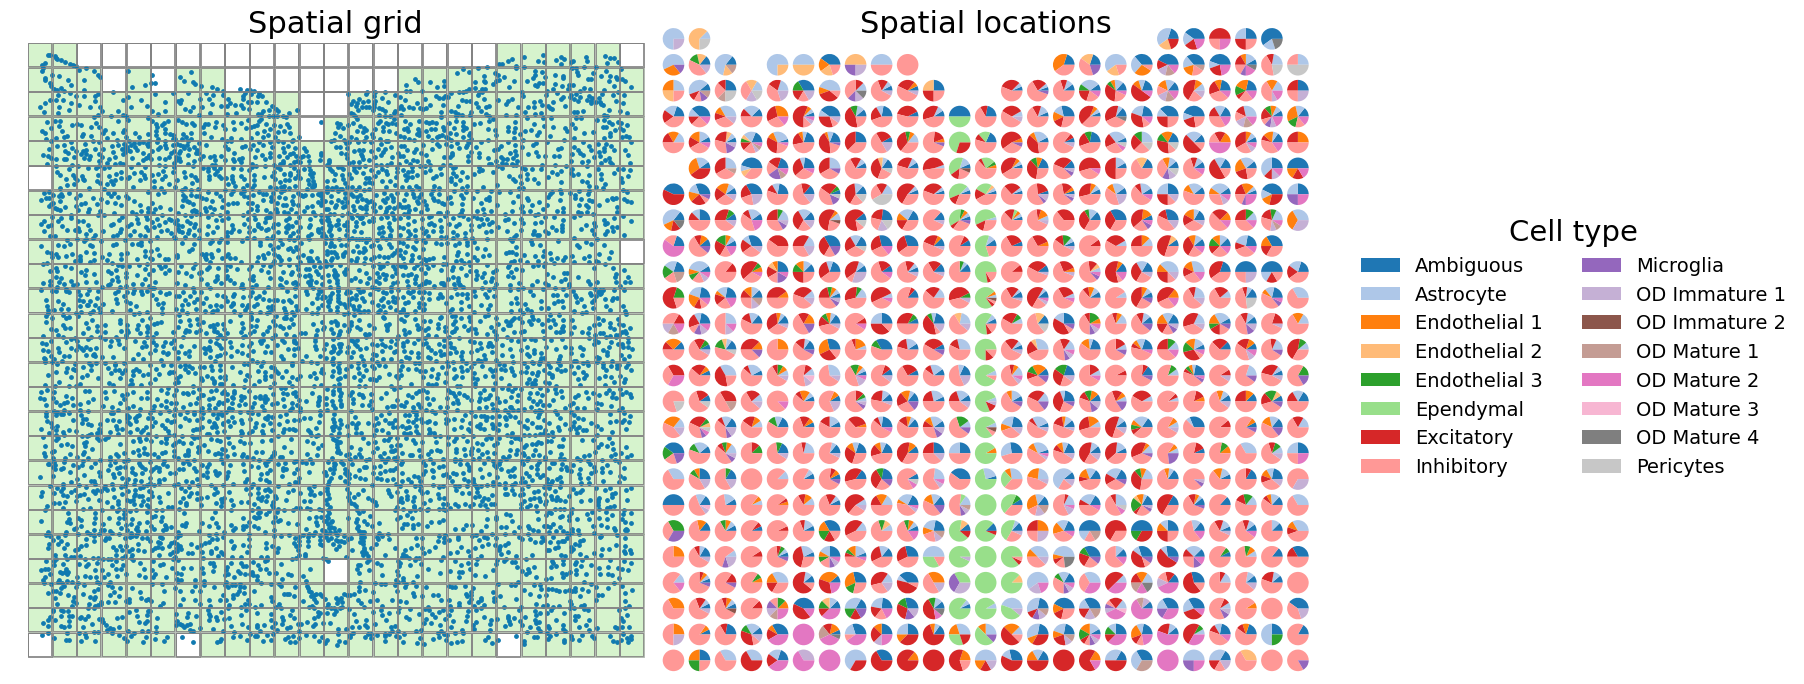

In [ ]:
figure = plt.figure(figsize=(13, 8.5))
figs = figure.subfigures(1, 2, width_ratios=(1,1))

labels = adata_sc.obs["cell_types"].unique().tolist()
labels.sort()
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)] + ["gold", "khaki", "lightseagreen"]

# UMAP + PCA
figs[0].suptitle(f'Spatial grid',fontsize=22,y=1.02)
ax = figs[0].subplots(1,1)
size = (figure.get_size_inches()*figure.dpi) / [2,1]
s = (np.max(size) - (6 * 27)) / (25)
s = s * 10

sc_selected = adata_sc[adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
sc_notselected = adata_sc[~adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
st_selected = adata_st[adata_st.obs['cell_count'] >= 3].obsm["spatial"].T
st_notselected = adata_st[~(adata_st.obs['cell_count'] >= 3)].obsm["spatial"].T
ax.scatter(*(np.tile(np.array([1,-1]),[st_selected.shape[1],1]).T * st_selected), 
           s=s, color="xkcd:light sage", alpha=0.6,marker="s",linewidths=0.60,edgecolors="grey")
ax.scatter(*(np.tile(np.array([1,-1]),[st_notselected.shape[1],1]).T * st_notselected), 
           s=s,color="white", alpha=1,marker="s",linewidths=0.60,edgecolors="grey")
ax.scatter(*(np.tile(np.array([1,-1]),[sc_selected.shape[1],1]).T * sc_selected), 
           s=6, color="xkcd:nice blue",alpha=1)

ax.scatter(*(np.tile(np.array([1,-1]),[(adata_st.obsm["spatial"]).T.shape[1],1]).T * adata_st.obsm["spatial"].T),
            s=s,color=None, marker="s",linewidths=0.60,edgecolors="grey",facecolors='none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


figs[1].suptitle(f'Spatial locations',fontsize=22,y=1.02)
x_num = 25
y_num = 25
f, axes = figs[1],figs[1].subplots(x_num, y_num,)
handles = {}
for ax, x_grid in zip(axes, range(0,x_num)):
    for y_ax, y_grid in zip(ax, range(0,y_num)):
        grid = x_num * x_grid + y_grid
        value_counts = adata_sc[adata_sc.obs["grid"].astype("int") == grid].obs["cell_types"].value_counts().sort_index()
        col = list(adata_sc[adata_sc.obs["grid"].astype("int") == grid].uns['cell_types_colors'])
        if not col: col = None
        
        value_counts.plot.pie(ax=y_ax, labeldistance=None, colors=col)
        y_ax.set_ylabel("")

lines_labels = [ax.get_legend_handles_labels() for ax in f.axes]
d = {}
for lines_label in lines_labels:
    for wedge,label in zip(*lines_label):
        d[label] = wedge
print(len(d))

labels = sorted(list(d.keys()))
handles = []
for label in labels:
    handles.append(d[label])
f.legend(handles, labels, loc='lower left', bbox_to_anchor=(1.05, 0.45), ncol=2, 
         frameon=False,fontsize=14,title_fontsize=21,
         title="Cell type")
f.subplots_adjust(wspace=-0, hspace=-0.05,top=0.9,bottom=0.35)

plt.tight_layout(pad=-0.1)
plt.show()

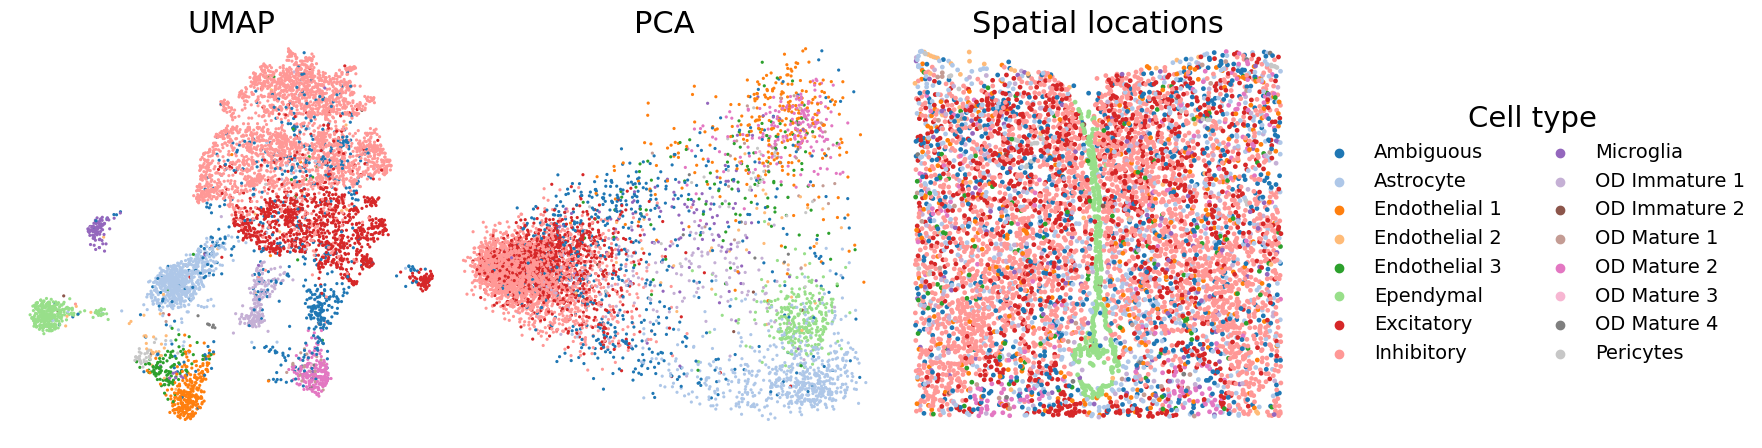

In [ ]:
figure = plt.figure(figsize=(13, 3.8))
figs = figure.subfigures(1, 3, width_ratios=(1,1,1.0,))

labels = adata_sc.obs["cell_types"].unique().tolist()
labels.sort()
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)] + ["gold", "khaki", "lightseagreen"]

# UMAP + PCA
figs[0].suptitle(f'UMAP',fontsize=22,y=1.09)
ax = figs[0].subplots(1,1)
sc.pl.umap(
    adata_sc, color="cell_types", 
    title="",
    size=21, frameon=False, 
    show=False, ax=ax,
    palette={label: color for label,color in zip(labels,colors)},
    legend_loc=None, alpha=1
)
figs[1].suptitle(f'PCA',fontsize=22,y=1.09)
ax = figs[1].subplots(1,1)
sc.pl.pca_scatter(
    adata_sc, color="cell_types", size=21, 
    title="",
    frameon=False, show=False, ax=ax,
    palette={label: color for label,color in zip(labels,colors)}, 
    alpha=1,legend_loc=None,
)

# spatial
figs[2].suptitle(f'Spatial locations',fontsize=22,y=1.09)
ax = figs[2].subplots(1,1)
sc.pl.spatial(
    adata_sc, color="cell_types", frameon=False, 
    show=False, ax=ax, spot_size=0.013,
    title="",
    legend_fontsize=14
)
ax.legend_.set_title("Cell type",prop={'size':21})

plt.tight_layout(pad=-1.0)
plt.show()

In [14]:
adata_sc.write("data/merfish_mouse_hypothalamus_sc.h5ad")
adata_st.write("data/merfish_mouse_hypothalamus_st.h5ad")

In [68]:
np.random.choice(adata_st.shape[0], adata_sc.shape[0])
for run in range(10):
    r = np.zeros((adata_sc.shape[0], adata_st.shape[0]))
    r[np.arange(adata_sc.shape[0]), np.random.choice(adata_st.shape[0], adata_sc.shape[0])] = 1
    np.save(f"random/{run}.npy", r)

In [11]:
tg.pp_adatas(adata_sc, adata_st)

160 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
sort overlapping genes 2
160 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [73]:
train_idx, test_idx = sklearn.model_selection.train_test_split(adata_sc.uns["overlap_genes"], test_size=0.15, random_state=1234)
np.save(f"data/merfish_mouse_hypothalamus_train_genes.npy", np.array(train_idx))
np.save(f"data/merfish_mouse_hypothalamus_test_genes.npy", np.array(test_idx))

160 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
sort overlapping genes 2
160 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [69]:
x = pd.DataFrame({"cl": adata_sc.obs["grid"]})
for i in np.unique(adata_sc.obs["grid"]):
    x[i] = list(map(int, x["cl"] == i))
del x["cl"]

In [70]:
true_adata_map = AnnData(X=x[adata_st.obs_names], 
                         obs=adata_sc.obs,
                         var=adata_st.obs)

In [ ]:
tg.project_cell_annotations(true_adata_map, adata_st, annotation="cell_types")
true_adata_map.varm["ct_map"] = adata_st.obsm["tangram_ct_pred"]
vmin =true_adata_map.varm["ct_map"].min()
vmax = true_adata_map.varm["ct_map"].max()
true_adata_map.varm["ct_map"] = (true_adata_map.varm["ct_map"] - vmin) / (vmax - vmin) 

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [ ]:
true_adata_map.write("data/merfish_mouse_hypothalamus_true_mapping.h5ad")

## SeqFISH+ mouse cortex dataset

https://github.com/CaiGroup/seqFISH-PLUS/blob/master/README.md

In [ ]:
cortex_svz_counts = pd.read_csv('../GCNG/seqfish_plus/cortex_svz_counts.csv')
cortex_svz_counts_N = cortex_svz_counts.div(cortex_svz_counts.sum(axis=1)+1, axis='rows')*10**4
cortex_svz_counts_N.columns =[i.lower() for i in list(cortex_svz_counts_N)] ## gene expression normalization
annotation = pd.concat([pd.read_csv('../GCNG/seqfish_plus/cortex_annotation.txt', sep="\t"),
                        pd.read_csv('../GCNG/seqfish_plus/cortex_svz_cellcentroids.csv'),
                        pd.read_csv('data/seqfish_cortex/cortex_svz_stiched_coords.csv')],
                        axis=1)
adata_sc = AnnData(X=cortex_svz_counts_N, 
                   obs=annotation,
                   obsm={"spatial" : np.array(annotation[['X_final', 'Y_final']].values.tolist())})

In [ ]:
adata_sc

AnnData object with n_obs × n_vars = 913 × 10000
    obs: 'uniq_ID', 'Field_of_View', 'cell_types', 'Field of View', 'Cell ID', 'X', 'Y', 'Region', 'Unnamed: 0', 'ID', 'X_final', 'Y_final'
    obsm: 'spatial'

In [596]:
adata_sc = adata_sc[adata_sc.obs["Region"] == "Cortex"].copy()
adata_sc = adata_sc[adata_sc.obs["Field of View"] < 5].copy()

In [599]:
adata_sc.obsm["spatial"][:,0] -= adata_sc.obsm["spatial"][:,0].min()
adata_sc.obsm["spatial"][:,0] /= adata_sc.obsm["spatial"][:,0].max()
adata_sc.obsm["spatial"][:,1] -= adata_sc.obsm["spatial"][:,1].min()
adata_sc.obsm["spatial"][:,1] /= adata_sc.obsm["spatial"][:,1].max()

In [84]:
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

         Falling back to preprocessing with `sc.pp.pca` and default params.


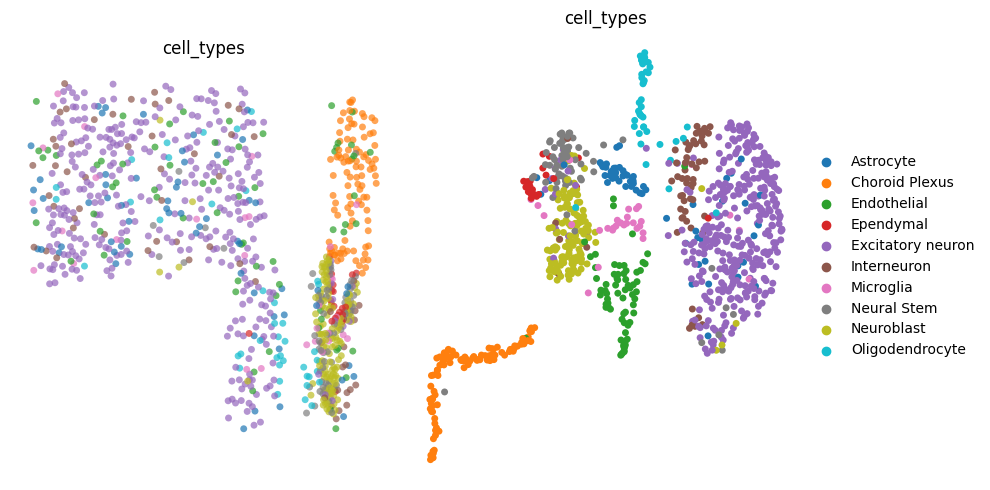

In [492]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.spatial(
    adata_sc, color="cell_types", alpha=0.7, frameon=False, show=False, ax=axs[0], spot_size=0.02,
    legend_loc=None
)
sc.pl.umap(
    adata_sc, color="cell_types", size=100, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

In [601]:
xgrid, ygrid = np.meshgrid(np.linspace(0, 1, 12),np.linspace(0, 1, 12))

In [116]:
adata_sc.obsm["spatial"][:,0] -= adata_sc.obsm["spatial"][:,0].min()
adata_sc.obsm["spatial"][:,1] -= adata_sc.obsm["spatial"][:,1].min()

xmin = adata_sc.obsm["spatial"][:,0].min()
xmax = adata_sc.obsm["spatial"][:,0].max()
ymin = adata_sc.obsm["spatial"][:,1].min()
ymax = adata_sc.obsm["spatial"][:,1].max()

xgrid, ygrid = np.meshgrid(np.linspace(xmin, xmax, 25),np.linspace(ymin, ymax, 8))

In [117]:
adata_st = tgx.generate_adata_st(adata_sc, xgrid, ygrid, 1, 3)

100%|██████████| 8/8 [00:00<00:00, 39.10it/s]

proportion of selected cells: 0.963855421686747


<Axes: >

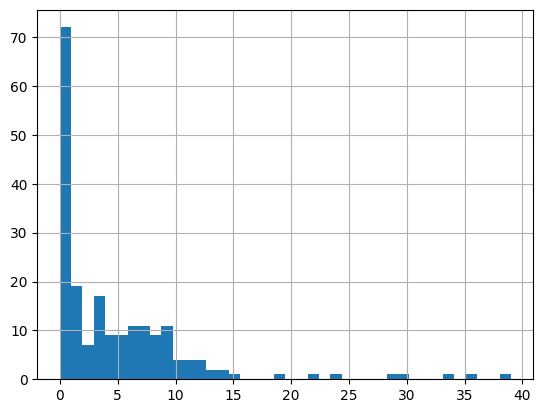

In [216]:
adata_st.obs['cell_count'].hist(bins=40)

In [610]:
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

In [120]:
adata_st = adata_st[adata_st.obs['cell_count'] >= 3]

In [397]:
adata_st.obs['cell_count'].mean()

11.175

In [121]:
adata_sc = adata_sc[adata_sc.obs['selected_for_adata_st_filtered']]
adata_sc

View of AnnData object with n_obs × n_vars = 880 × 10000
    obs: 'uniq_ID', 'Field_of_View', 'cell_types', 'Field of View', 'Cell ID', 'X', 'Y', 'Region', 'Unnamed: 0', 'ID', 'X_final', 'Y_final', 'selected_for_adata_st', 'selected_for_adata_st_filtered', 'grid'
    uns: 'cell_types_colors', 'log1p'
    obsm: 'spatial'

In [118]:
tgx.cells2spots(adata_sc, adata_st)

In [119]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)

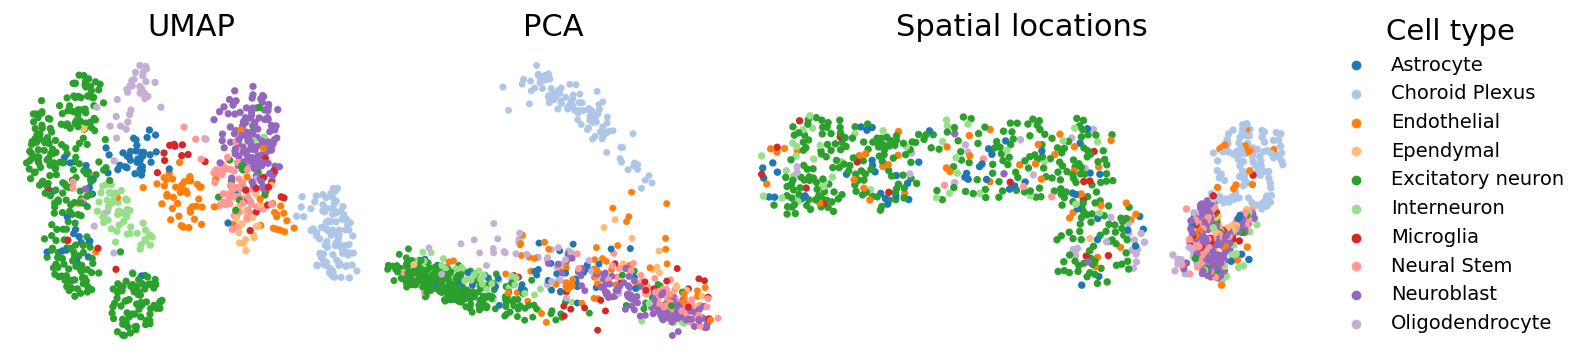

In [ ]:
figure = plt.figure(figsize=(13, 3.5))
figs = figure.subfigures(1, 3, width_ratios=(1,1,1.6,))

labels = adata_sc.obs["cell_types"].unique().tolist()
labels.sort()
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)] + ["gold", "khaki", "lightseagreen"]

# UMAP + PCA
figs[0].suptitle(f'UMAP',fontsize=22,y=0.98)
ax = figs[0].subplots(1,1)
sc.pl.umap(
    adata_sc, color="cell_types", 
    title="",
    size=110, frameon=False, 
    show=False, ax=ax,
    palette={label: color for label,color in zip(labels,colors)},
    legend_loc=None, alpha=1
)
figs[1].suptitle(f'PCA',fontsize=22,y=0.98)
ax = figs[1].subplots(1,1)
sc.pl.pca_scatter(
    adata_sc, color="cell_types", size=100, 
    title="",
    frameon=False, show=False, ax=ax,
    palette={label: color for label,color in zip(labels,colors)}, 
    alpha=1,legend_loc=None,
)

# spatial
figs[2].suptitle(f'Spatial locations',fontsize=22,y=0.98)
ax = figs[2].subplots(1,1)
sc.pl.spatial(
    adata_sc, color="cell_types", frameon=False, 
    show=False, ax=ax, spot_size=140,#0.013,
    title="",
    legend_fontsize=14
)
ax.legend_.set_bbox_to_anchor((1.01, 0.63))
ax.legend_.set_title("Cell type",prop={'size':21})
plt.tight_layout(pad=-0.3)
plt.show()

10


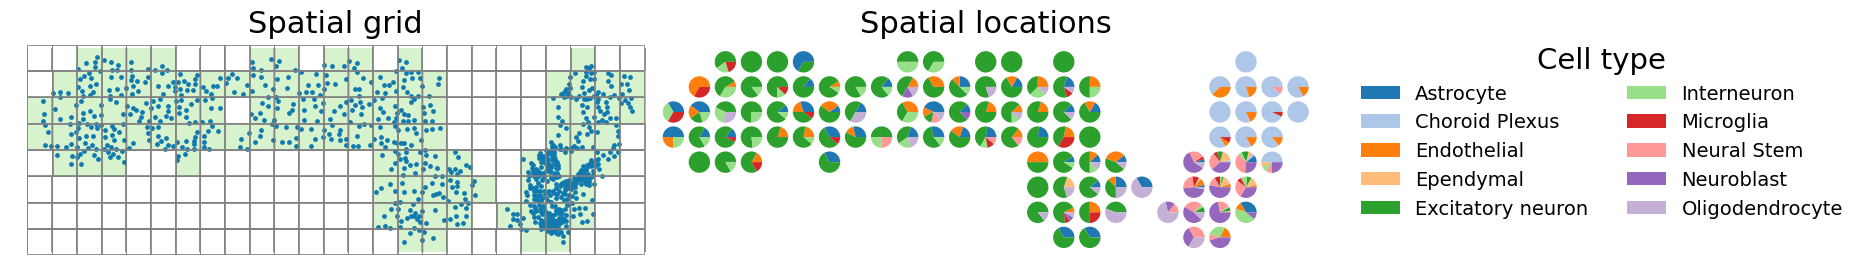

In [ ]:
figure = plt.figure(figsize=(13, 2))#8.5))
figs = figure.subfigures(1, 2, width_ratios=(1,1))

labels = adata_sc.obs["cell_types"].unique().tolist()
labels.sort()
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)] + ["gold", "khaki", "lightseagreen"]

# UMAP + PCA
figs[0].suptitle(f'Spatial grid',fontsize=22,y=1.2,)
ax = figs[0].subplots(1,1,)
figs[0].subplots_adjust(bottom=0.15)
size = (figure.get_size_inches()*figure.dpi) / [2,1]
s = (1.3 * (size[0]-12) / (25))
s = s * 10

sc_selected = adata_sc[adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
sc_notselected = adata_sc[~adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
st_selected = adata_st[adata_st.obs['cell_count'] >= 3].obsm["spatial"].T
st_notselected = adata_st[~(adata_st.obs['cell_count'] >= 3)].obsm["spatial"].T
ax.scatter(*(np.tile(np.array([1,-1]),[st_selected.shape[1],1]).T * st_selected), 
           s=s, color="xkcd:light sage", alpha=0.6,marker="s",linewidths=0.6,edgecolors="grey")
ax.scatter(*(np.tile(np.array([1,-1]),[st_notselected.shape[1],1]).T * st_notselected), 
           s=s,color="white", alpha=1,marker="s",linewidths=0.6,edgecolors="grey")
ax.scatter(*(np.tile(np.array([1,-1]),[sc_selected.shape[1],1]).T * sc_selected), 
           s=6, color="xkcd:nice blue",alpha=1)

ax.scatter(*(np.tile(np.array([1,-1]),[(adata_st.obsm["spatial"]).T.shape[1],1]).T * adata_st.obsm["spatial"].T),
    #*(adata_st.obsm["spatial"]).T
           s=s,color=None, marker="s",linewidths=0.6,edgecolors="grey",facecolors='none',clip_on=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


figs[1].suptitle(f'Spatial locations',fontsize=22,y=1.2)
x_num = 8#25
y_num = 25#8
f, axes = figs[1],figs[1].subplots(x_num, y_num,)# figsize=(5,5))
#f.tight_layout(pad=-2.0)
handles = {}
for ax, x_grid in zip(axes, range(0,x_num)):
    for y_ax, y_grid in zip(ax, range(0,y_num)):
        grid = y_num * x_grid + y_grid
        #grid = x_num * x_grid + y_grid
        value_counts = adata_sc[adata_sc.obs["grid"].astype("int") == grid].obs["cell_types"].value_counts().sort_index()
        col = list(adata_sc[adata_sc.obs["grid"].astype("int") == grid].uns['cell_types_colors'])
        if not col: col = None
        
        value_counts.plot.pie(ax=y_ax, labeldistance=None, colors=col)
        y_ax.set_ylabel("")


lines_labels = [ax.get_legend_handles_labels() for ax in f.axes]
d = {}
for lines_label in lines_labels:
    for wedge,label in zip(*lines_label):
        d[label] = wedge
print(len(d))

labels = sorted(list(d.keys()))
handles = []
for label in labels:
    handles.append(d[label])
f.legend(handles, labels, loc='lower left', bbox_to_anchor=(1.05, 0.07), ncol=2, 
         frameon=False,fontsize=14,title_fontsize=21,
         title="Cell type")
f.subplots_adjust(wspace=-0, hspace=-0.05,top=0.9,bottom=0.1)

plt.tight_layout(pad=-0.1)
figure.savefig("lol.png", transparent=True, bbox_inches='tight',)
plt.show()

In [68]:
adata_sc.write("data/seqfish+_mouse_cortex_sc.h5ad")
adata_st.write("data/seqfish+_mouse_cortex_st.h5ad")

In [17]:
tg.pp_adatas(adata_sc, adata_st)

10000 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
sort overlapping genes 2
10000 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [75]:
train_idx, test_idx = sklearn.model_selection.train_test_split(adata_sc.uns["overlap_genes"], test_size=0.15, random_state=1234)
np.save(f"data/seqfish+_mouse_cortex_train_genes.npy", np.array(train_idx))
np.save(f"data/seqfish+_mouse_cortex_test_genes.npy", np.array(test_idx))

10000 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
sort overlapping genes 2
10000 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [131]:
x = pd.DataFrame({"cl": adata_sc.obs["grid"]})
for i in np.unique(adata_sc.obs["grid"]):
    x[i] = list(map(int, x["cl"] == i))
del x["cl"]

In [132]:
true_adata_map = AnnData(X=x[adata_st.obs_names], 
                         obs=adata_sc.obs,
                         var=adata_st.obs)

In [ ]:
tg.project_cell_annotations(true_adata_map, adata_st, annotation="cell_types")
true_adata_map.varm["ct_map"] = adata_st.obsm["tangram_ct_pred"]
vmin =true_adata_map.varm["ct_map"].min()
vmax = true_adata_map.varm["ct_map"].max()
true_adata_map.varm["ct_map"] = (true_adata_map.varm["ct_map"] - vmin) / (vmax - vmin) 

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [ ]:
true_adata_map.write("data/seqfish+_mouse_cortex_true_mapping.h5ad")

In [130]:
np.random.choice(adata_st.shape[0], adata_sc.shape[0])
for run in range(10):
    r = np.zeros((adata_sc.shape[0], adata_st.shape[0]))
    r[np.arange(adata_sc.shape[0]), np.random.choice(adata_st.shape[0], adata_sc.shape[0])] = 1
    np.save(f"random/{run}.npy", r)

## SeqFISH mouse embryo dataset

In [2]:
adata_sc = sq.datasets.seqfish()

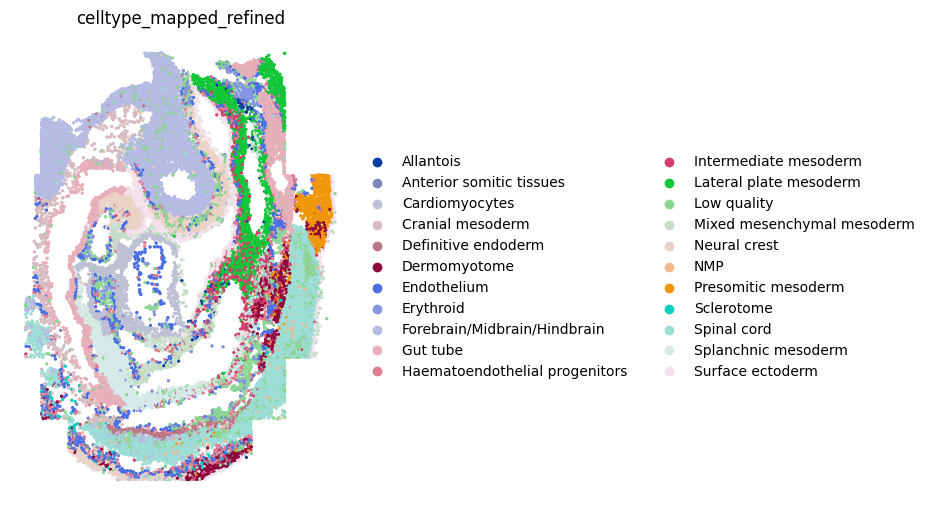

In [394]:
sq.pl.spatial_scatter(
    adata_sc, shape=None, color="celltype_mapped_refined", frameon=False, figsize = (10,5),# return_ax=True# ax=ax
)

In [11]:
adata_sc.obsm["spatial"][:,0]

(19416, 2)

In [4]:
adata_sc.obsm["spatial"][:,0] -= adata_sc.obsm["spatial"][:,0].min()
adata_sc.obsm["spatial"][:,1] -= adata_sc.obsm["spatial"][:,1].min()

xmin = adata_sc.obsm["spatial"][:,0].min()
xmax = adata_sc.obsm["spatial"][:,0].max()
ymin = adata_sc.obsm["spatial"][:,1].min()
ymax = adata_sc.obsm["spatial"][:,1].max()

xgrid, ygrid = np.meshgrid(np.linspace(xmin, xmax, 45),np.linspace(ymin, ymax, 62))

In [8]:
adata_st = tgx.generate_adata_st(adata_sc, xgrid, ygrid, cell_cover=0.8,min_cell_count=3)

100%|██████████| 62/62 [01:18<00:00,  1.27s/it]

proportion of selected cells: 0.6146992171405027


In [9]:
adata_st[adata_st.obs['cell_count'] >= 3].obs['cell_count'].mean()

7.91970802919708

<Axes: >

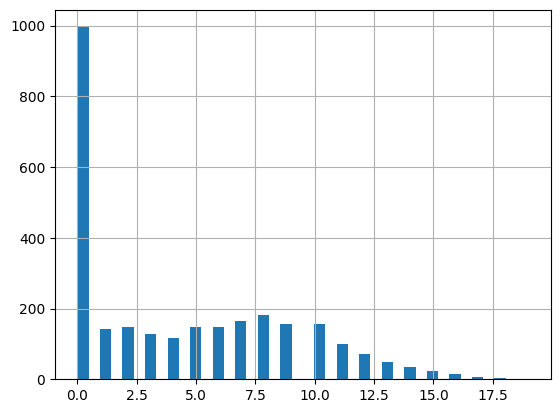

In [10]:
adata_st.obs['cell_count'].hist(bins=40)

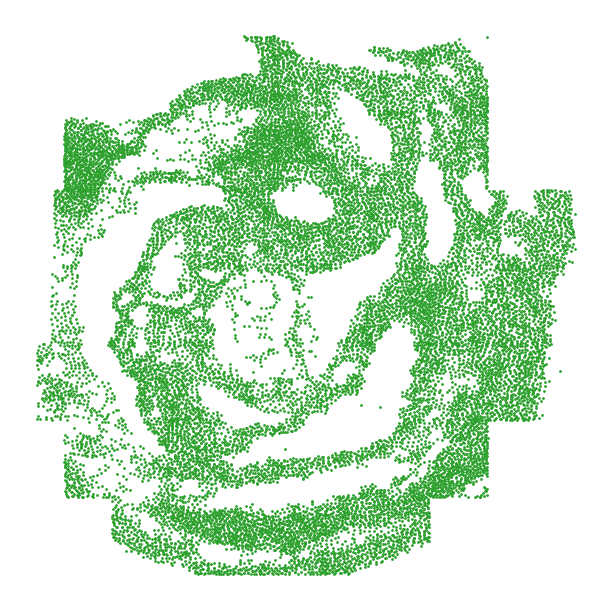

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')

sc_selected = adata_sc[adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
sc_notselected = adata_sc[~adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
st_selected = adata_st2[adata_st2.obs['cell_count'] >= 3].obsm["spatial"].T
st_notselected = adata_st2[~(adata_st2.obs['cell_count'] >= 3)].obsm["spatial"].T
ax.scatter(*(np.tile(np.array([1,-1]),[sc_selected.shape[1],1]).T * sc_selected), s=1, color="tab:green")
ax.scatter(*(np.tile(np.array([1,-1]),[sc_notselected.shape[1],1]).T * sc_notselected), s=1, color="tab:green")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

In [9]:
adata_st = tgx.generate_adata_st(adata_sc, xgrid, ygrid, cell_cover=0.7,min_cell_count=3)

100%|██████████| 40/40 [00:53<00:00,  1.33s/it]

proportion of selected cells: 0.4741450350226617


9467bd

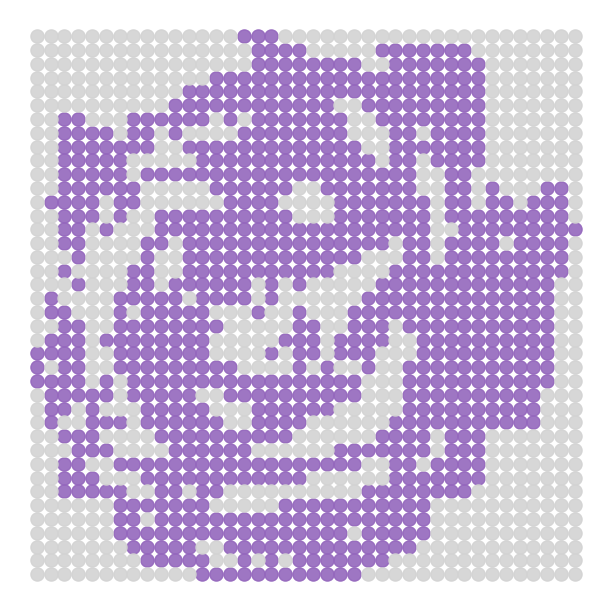

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')

sc_selected = adata_sc[adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
sc_notselected = adata_sc[~adata_sc.obs['selected_for_adata_st_filtered']].obsm["spatial"].T
st_selected = adata_st[adata_st.obs['cell_count'] >= 3].obsm["spatial"].T
st_notselected = adata_st[~(adata_st.obs['cell_count'] >= 3)].obsm["spatial"].T
ax.scatter(*(np.tile(np.array([1,-1]),[st_selected.shape[1],1]).T * st_selected), s=90, color="tab:purple", alpha=0.9)
ax.scatter(*(np.tile(np.array([1,-1]),[st_notselected.shape[1],1]).T * st_notselected), s=90, color="lightgray", alpha=0.9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.savefig('poster_plots/data_st.png',bbox_inches='tight',transparent=True, pad_inches=0.05)

In [11]:
adata_st = adata_st[adata_st.obs['cell_count'] >= 3]

In [93]:
adata_sc = adata_sc[adata_sc.obs['selected_for_adata_st_filtered']]

In [13]:
tgx.cells2spots(adata_sc, adata_st)

In [98]:
adata_sc.obs["cell_types"] = adata_sc.obs["celltype_mapped_refined"]

In [14]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)

In [414]:
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

In [105]:
adata_st.obsm["spatial"] /= adata_st.obsm["spatial"].max()

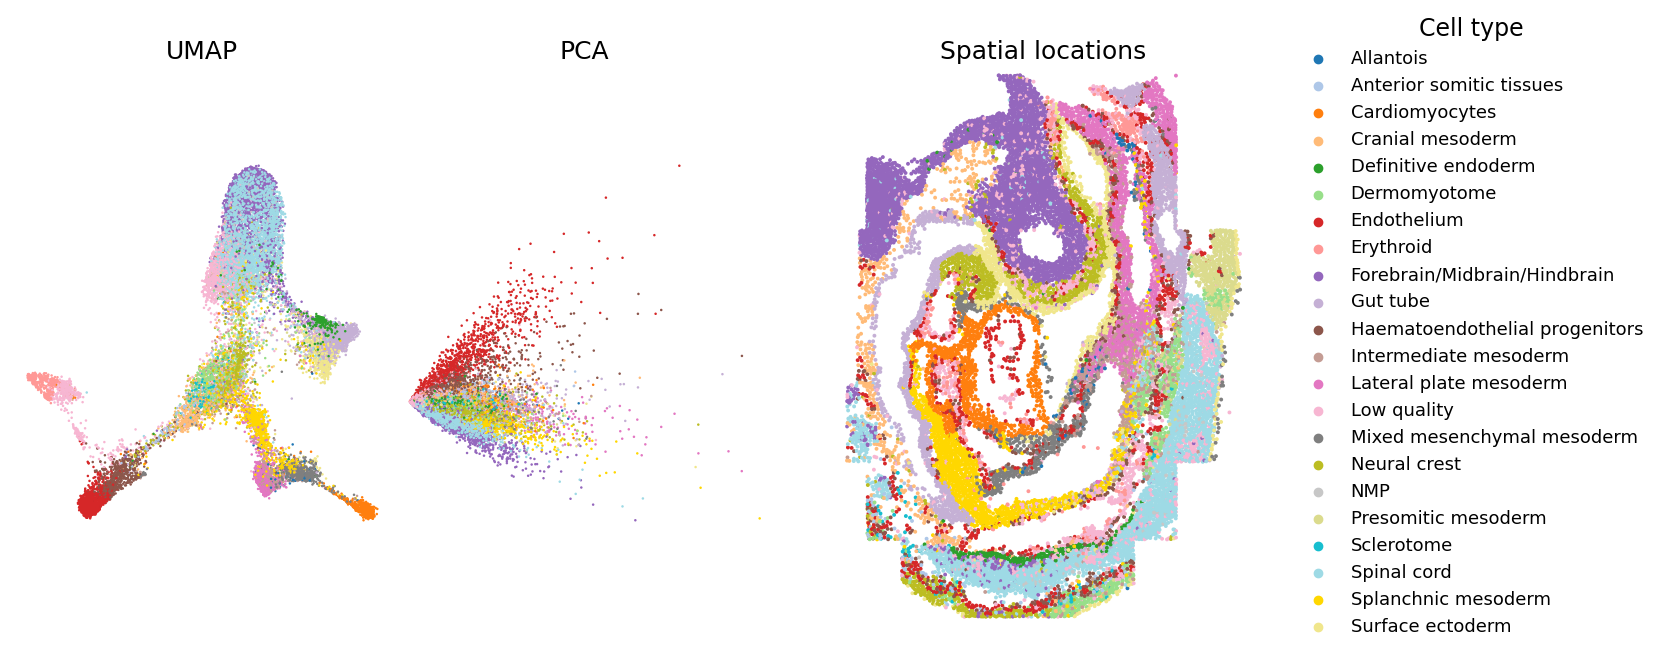

In [ ]:
figure = plt.figure(figsize=(13, 6.0))
figs = figure.subfigures(1, 3, width_ratios=(1.0,1.0,1.4,))


labels = adata_sc.obs["cell_types"].unique().tolist()
labels.sort()
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)] + ["gold", "khaki", "lightseagreen"]

# UMAP + PCA
figs[0].suptitle(f'UMAP',fontsize=18,y=1.01)
ax = figs[0].subplots(1,1)
sc.pl.umap(
    adata_sc, color="cell_types", 
    title="",
    size=13, frameon=False, 
    show=False, ax=ax,
    palette={label: color for label,color in zip(labels,colors)},
    legend_loc=None, alpha=1,hspace=0.8
)
figs[1].suptitle(f'PCA',fontsize=18,y=1.01)
ax = figs[1].subplots(1,1)
sc.pl.pca_scatter(
    adata_sc, color="cell_types", size=13, 
    title="",
    frameon=False, show=False, ax=ax,
    palette={label: color for label,color in zip(labels,colors)}, 
    alpha=1,legend_loc=None,
)

# spatial
figs[2].suptitle(f'Spatial locations',fontsize=18,y=1.01)

ax = figs[2].subplots(1,1)
sc.pl.spatial(
    adata_sc, color="cell_types", frameon=False, 
    show=False, ax=ax, spot_size=0.05,
    title="",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(1.05, -0.01), ncol=1, #1.1, 0.5
         frameon=False,fontsize=13,title_fontsize=17,
         title="Cell type")
plt.tight_layout(pad=-0.3)
figs[2].subplots_adjust(top=1,bottom=0)
figs[0].subplots_adjust(top=0.83,bottom=0.18)
figs[1].subplots_adjust(top=0.83,bottom=0.18)
plt.show()

In [25]:
adata_sc.write("data/seqfish_mouse_embryo_sc.h5ad")
adata_st.write("data/seqfish_mouse_embryo_st.h5ad")

In [24]:
tg.pp_adatas(adata_sc, adata_st)

351 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
sort overlapping genes 2
351 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [36]:
train_idx, test_idx = sklearn.model_selection.train_test_split(adata_sc.uns["overlap_genes"], test_size=0.15, random_state=1234)

In [38]:
np.save(f"data/seqfish_mouse_embryo_train_genes.npy", np.array(train_idx))
np.save(f"data/seqfish_mouse_embryo_test_genes.npy", np.array(test_idx))

In [16]:
np.random.choice(adata_st.shape[0], adata_sc.shape[0])
for run in range(10):
    r = np.zeros((adata_sc.shape[0], adata_st.shape[0]))
    r[np.arange(adata_sc.shape[0]), np.random.choice(adata_st.shape[0], adata_sc.shape[0])] = 1
    np.save(f"random/{run}.npy", r)

In [17]:
x = pd.DataFrame({"cl": adata_sc.obs["grid"]})
for i in np.unique(adata_sc.obs["grid"]):
    x[i] = list(map(int, x["cl"] == i))
del x["cl"]

In [21]:
true_adata_map = AnnData(X=x[adata_st.obs_names], 
                         obs=adata_sc.obs,
                         var=adata_st.obs)

In [19]:
adata_sc.obs["cell_types"] = adata_sc.obs['celltype_mapped_refined']

In [ ]:
tg.project_cell_annotations(true_adata_map, adata_st, annotation="cell_types")
true_adata_map.varm["ct_map"] = adata_st.obsm["tangram_ct_pred"]
vmin =true_adata_map.varm["ct_map"].min()
vmax = true_adata_map.varm["ct_map"].max()
true_adata_map.varm["ct_map"] = (true_adata_map.varm["ct_map"] - vmin) / (vmax - vmin) 

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [ ]:
true_adata_map.write("data/seqfish_mouse_embryo_true_mapping.h5ad")